In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

C:\Users\erich\AppData\Local\Temp\ipykernel_8996\358196874.py:3: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.integrate import odeint


Data generated!
Training data shape: (2000, 4)
True Parameters to recover: D=0.1, r=1.0


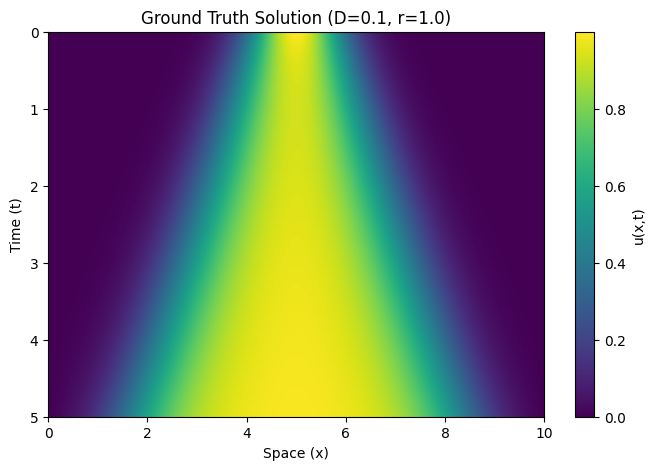

In [7]:
# Forward "True" Solver

D_true = 0.1  # Diffusion coefficient
r_true = 1.0  # Reaction rate

# Relevant Domain
L = 10.0      # Length of domain (e.g., x from 0 to 10)
T = 5.0       # Total time (e.g., t from 0 to 5)
Nx = 200      # Spatial resolution
Nt = 200      # Temporal resolution

# Noise and Sparsity
noise_level = 0.05  # 5% random noise
num_train_samples = 2000 

# Solver
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)
dx = x[1] - x[0]

# Initial Condition: A Gaussian pulse centered in the domain
u0 = np.exp(-(x - L/2)**2)

def kpp_rhs(u, t, D, r, dx):
    """This is a true forward solver for the KPP-Fisher equation.

    Args:
        u (array): solution
        t (scalar): time
        D (scalar): diffusion coefficient
        r (scalar): reaction state
        dx (scalar): step size

    Returns:
        array: full solution at each time step
    """
    # Finite difference approximation for u_xx
    # u_xx approx (u[i+1] - 2u[i] + u[i-1]) / dx^2
    # We assume Dirichlet BCs (u=0 at boundaries)

    dudt = np.zeros_like(u)
    
    # Laplacian (Diffusion)
    diffusion = D * (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2
    
    # Reaction: r * u * (1 - u)
    reaction = r * u[1:-1] * (1 - u[1:-1])
    
    dudt[1:-1] = diffusion + reaction
    return dudt

# Solve the PDE
solution = odeint(kpp_rhs, u0, t, args=(D_true, r_true, dx))

# Label Data for Feeding into Neural Network

# Create meshgrid to associate every u value with an (x, t) coordinate
X_grid, T_grid = np.meshgrid(x, t)

# Flatten data for export
x_flat = X_grid.flatten()
t_flat = T_grid.flatten()
u_flat = solution.flatten()

# Add Noise
u_noisy = u_flat + noise_level * np.std(u_flat) * np.random.randn(len(u_flat))

# Create a DataFrame
df = pd.DataFrame({
    't': t_flat,
    'x': x_flat,
    'u_exact': u_flat,
    'u_noisy': u_noisy
})

# --- Sparsity (Subsampling) ---
# Randomly sample 'num_train_samples' points for training
train_df = df.sample(n=num_train_samples, random_state=42)

# Save the files
train_df.to_csv("kpp_training_data.csv", index=False)

print("Data generated!")
print(f"Training data shape: {train_df.shape}")
print(f"True Parameters to recover: D={D_true}, r={r_true}")

# Visualize the ground truth
plt.figure(figsize=(8, 5))
plt.imshow(solution, aspect='auto', extent=[0, L, T, 0], cmap='viridis', origin='upper')
plt.colorbar(label='u(x,t)')
plt.title(f"Ground Truth Solution (D={D_true}, r={r_true})")
plt.xlabel("Space (x)")
plt.ylabel("Time (t)")
plt.show()

In [3]:
class KPPDataset(Dataset):
    def __init__(self, csv_file):
        # Load data
        data = pd.read_csv(csv_file)
        
        # Inputs: t and x
        self.X = data[['t', 'x']].values.astype(np.float32)
        # Target: u (noisy observations)
        self.u = data['u_noisy'].values.astype(np.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.u)

    def __getitem__(self, idx):
        return self.X[idx], self.u[idx]

In [ ]:
class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super(PhysicsInformedNN, self).__init__()
        
        # Approximator for u
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )
        
        # 2. The Inverse Parameters (What we want to discover)
        # We initialize them randomly (e.g., 0.5) and let the network correct them.
        self.D = nn.Parameter(torch.tensor([0.5], dtype=torch.float32))
        self.r = nn.Parameter(torch.tensor([0.5], dtype=torch.float32))

    def forward(self, x):
        return self.net(x)

In [5]:
def physics_loss(model, inputs):
    # Enable gradient tracking for inputs (t, x) to compute partial derivatives
    inputs.requires_grad_(True)
    
    # Predict u using the network
    u_pred = model(inputs)
    
    # Extract t and x specifically for clarity
    t = inputs[:, 0:1]
    x = inputs[:, 1:2]
    
    # --- Automatic Differentiation ---
    # First derivatives (du/dt and du/dx)
    grads = torch.autograd.grad(u_pred, inputs, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_t = grads[:, 0:1] # Partial with respect to t
    u_x = grads[:, 1:2] # Partial with respect to x
    
    # Second derivative (d^2u/dx^2)
    # Note: We must differentiate u_x w.r.t inputs again
    grads_2 = torch.autograd.grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xx = grads_2[:, 1:2] # Partial w.r.t x again

    # --- KPP Equation Residual ---
    # u_t - D*u_xx - r*u*(1-u) = 0
    f = u_t - model.D * u_xx - model.r * u_pred * (1 - u_pred)
    
    return torch.mean(f**2)

In [6]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = KPPDataset("kpp_training_data.csv")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = PhysicsInformedNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000

for epoch in range(epochs):
    for batch_X, batch_u in dataloader:
        batch_X, batch_u = batch_X.to(device), batch_u.to(device)
        
        # 1. Forward Pass (Data Loss)
        u_pred = model(batch_X)
        loss_u = torch.mean((u_pred - batch_u)**2)
        
        # 2. Physics Loss
        # We sample random points within the domain for physics constraints
        # (Here reusing batch points for simplicity, but often people sample uniformly from domain)
        loss_f = physics_loss(model, batch_X)
        
        # 3. Total Loss
        loss = loss_u + loss_f
        
        # 4. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.5f}, D_est: {model.D.item():.4f}, r_est: {model.r.item():.4f}")

print("Training Complete.")
print(f"Final Discovered Parameters: D = {model.D.item():.4f}, r = {model.r.item():.4f}")

Epoch 0: Loss 0.09358, D_est: 0.5089, r_est: 0.4757
Epoch 500: Loss 0.00067, D_est: 0.0967, r_est: 0.9994
Epoch 1000: Loss 0.00024, D_est: 0.0960, r_est: 0.9998
Epoch 1500: Loss 0.00031, D_est: 0.0974, r_est: 1.0010
Epoch 2000: Loss 0.00084, D_est: 0.0972, r_est: 0.9987
Epoch 2500: Loss 0.00045, D_est: 0.0973, r_est: 1.0009
Epoch 3000: Loss 0.00032, D_est: 0.0962, r_est: 1.0037
Epoch 3500: Loss 0.00046, D_est: 0.0985, r_est: 1.0028
Epoch 4000: Loss 0.00045, D_est: 0.0982, r_est: 1.0034
Epoch 4500: Loss 0.00049, D_est: 0.1001, r_est: 1.0009
Training Complete.
Final Discovered Parameters: D = 0.0975, r = 1.0018
